# Practicum II Part I

##  Accuracy of stacked supervised machine learning models for detection of denial of service https unbearable load king attacks from the Canadian Institute of Cybersecurity from 2017-2019. 

* ML is based in finding patterns in data so as to make predictions.
* As such, it has seen extensive use in cybersecurity implementations.
* Most prominently it has been used to identify irregular traffic in a company’s network to root out a particular cyberattack.
* It can retrospectively examine data to understand how cyberattacks are targeting a particular aspect of the company and their methods of doing so.
* DoS attacks are considered to be the most damaging type of attack in the industry due to their purpose of shutting down services offered by the company.
* Many modern Machine Learning based solutions exist for this problem.
* This paper explores a solution in the form of stacked supervised machine learning models. 

**Objective**
* This project will explore how accurately can supervised machine learning models detect DoS HULK attack from the chosen datasets.
* Through analyzing the performance of popular models such as the Support Vector Machine, Random Forests, and Decision Trees,  the research will evaluate the accuracy of the models through the model’s accuracy metric, false positive and negative statistics in relation to the model type and complexity.
* Design and develop an open-source threat detection security system based on supervised machine learning models.
* Evaluate detection metrics of the system against published research results. 

## Data 
* The type of data required by the study is of retrospective nature and related to security incidents. 
* Models must use previous security events to predict future security events. 
* This study will implement currently existing data gathered by researcher from the Canadian Institute of Cybersecurity: CICIDS-2017, CICIDS-2018, and CICIDS2019.
* It is a varied source of cyberthreat data covering multiple functionally different attack types such as DoS HULK to brute force to botnets. 
* It has its different attacks spread throughout a seven day week
* Due to the total size of all three datasets totaling one terabyte and the constraints of available computational power, a reduced merged version was used for model strategy evaluation.

* CICIDS2017: https://www.unb.ca/cic/datasets/ids-2017.html
* CICIDS 2018: https://www.unb.ca/cic/datasets/ids-2018.html
* CICIDS 2019: https://www.unb.ca/cic/datasets/ddos-2019.html
* Data parquet file used is a collective version of the above datasets. It was acquired from https://www.kaggle.com/datasets/dhoogla/cicidscollection/data .
* There are 158,469 HULK attack observations, while there are 1,657,069 benign observations.


## Import Libraries

In [21]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier



## Process Data

* Exploratory Data Analysis will be used to identify patterns between the most relevant features in relation to the type of attack (benign and HULK).
* Correlation calculations and graphics such as a heatmap will be used to estimate the most important features to be used in model training. 
* Parquet file is loaded.
* Column names are cleaned of whitespaces.
* Case of values is normalized.
* Data is shuffled.
* Used feature columns are extracted.
* One-hot encoding was implemented. 
* Features are scaled. 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209547 entries, 0 to 209546
Data columns (total 78 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Protocol                  209547 non-null  int8   
 1   Flow Duration             209547 non-null  int32  
 2   Total Fwd Packets         209547 non-null  int16  
 3   Total Backward Packets    209547 non-null  int16  
 4   Fwd Packets Length Total  209547 non-null  float32
 5   Bwd Packets Length Total  209547 non-null  float32
 6   Fwd Packet Length Max     209547 non-null  float32
 7   Fwd Packet Length Min     209547 non-null  float32
 8   Fwd Packet Length Mean    209547 non-null  float32
 9   Fwd Packet Length Std     209547 non-null  float32
 10  Bwd Packet Length Max     209547 non-null  float32
 11  Bwd Packet Length Min     209547 non-null  float32
 12  Bwd Packet Length Mean    209547 non-null  float32
 13  Bwd Packet Length Std     209547 non-null  f

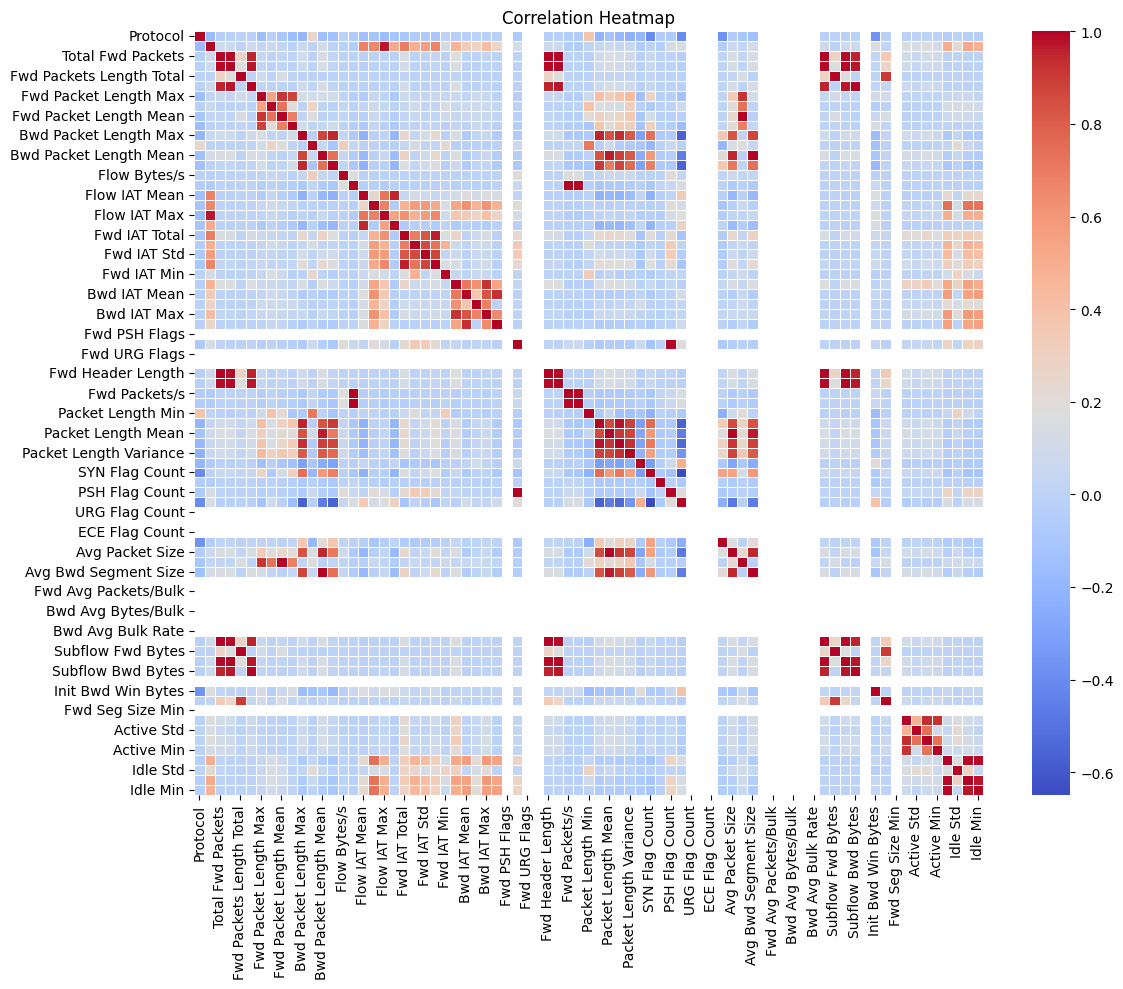

Series([], dtype: int64)


In [19]:
df = pd.read_parquet("cicdos.parquet")
df.columns = [c.strip() for c in df.columns]

if 'Label' not in df.columns:
    for c in ['label', ' LABEL', 'Label ']:
        if c in df.columns:
            df.rename(columns={c: 'Label'}, inplace=True)
            break

df['Label'] = df['Label'].astype(str).str.strip().str.upper()

df = df[df['Label'].isin(['BENIGN', 'HULK'])]

df = df.sample(frac=1, random_state=42).reset_index(drop=True)
features = []
for col in df.columns:
    if col != 'Label' and pd.api.types.is_numeric_dtype(df[col]):
        features.append(col)
        

print(df.info())
print(df.describe())


numDf = df.select_dtypes(include=['number'])
correl = numDf.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correl, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

print(df.isnull().sum()[df.isnull().sum() > 0])

## Feature Selection

In [ ]:

features = ['Flow Bytes/s','Flow IAT Mean','Fwd Packet Length Max','Bwd Packet Length Max','Packet Length Mean','Packet Length Variance','SYN Flag Count','PSH Flag Count','Avg Packet Size','Subflow Fwd Bytes']
X = df[features]
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)
X = X.values.astype(np.float32)

y = LabelEncoder().fit_transform(df['Label'])

scaler = StandardScaler()

X = scaler.fit_transform(X)



## Model training
* Support Vector Machines, Random Forest, and Decision Trees are trained and fit.
* The models will be trained only on the benign and HULK labelled observations.
* The models will be fine-tuned through a series of iterative grid search algorithms. 
* Another separate Decision Tree model will be trained to interpret the outputs of the previous models in relation to the potential threat to determine if the observation is a threat. 
* Split the models for training and testing, 70%:30%. 



In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

SVM = SVC(probability=True, class_weight='balanced', random_state=42)
RF = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
DT = DecisionTreeClassifier(class_weight='balanced', random_state=42)

SVM.fit(X_train, y_train)
RF.fit(X_train, y_train)
DT.fit(X_train, y_train)

labeler = LabelEncoder()
labeler.fit(df['Label'])
classes = list(labeler.classes_)
hulkIndex = classes.index('HULK')

SVMTrain = SVM.predict_proba(X_train)[:, hulkIndex]
RFTrain = RF.predict_proba(X_train)[:, hulkIndex]
DTTrain = DT.predict_proba(X_train)[:, hulkIndex]

SVMTest = SVM.predict_proba(X_test)[:, hulkIndex]
RFTest = RF.predict_proba(X_test)[:, hulkIndex]
DTTest = DT.predict_proba(X_test)[:, hulkIndex]
stackTrain = np.column_stack((SVMTrain, RFTrain, DTTrain))
stackTest = np.column_stack((SVMTest, RFTest, DTTest))

## Train meta model
* A separate Decision Tree will be trained on the predictions of the previous three models to predict the right answer.

In [16]:

meta = DecisionTreeClassifier(class_weight='balanced', random_state=99)
meta.fit(stackTrain, y_train)
y_pred = meta.predict(stackTest)


## Results

In [18]:

accuracy = accuracy_score(y_test, y_pred)

confMatrix = confusion_matrix(y_test, y_pred)
trueN, falseP, falseN, trueP = confMatrix.ravel()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (TPR): {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"False Positives: {falseP}")
print(f"False Negatives: {falseN}")




Accuracy: 0.9994
Precision: 0.9476
Recall (TPR): 0.8884
F1 Score: 0.9171
False Positives: 11
False Negatives: 25



The results indicate that a stacked classification strategy is highly optimal in terms of predictive accuracy when detecting DoS HULK attacks in the CICIDS 2017-2019 datasets. The final accuracy reads to be 99.94% as well as it proves its prediction consistency as its precision is 94.76%. This statement is backed by the recall of 0.88 and F1 score of 0.91. 

There were about 25 false negatives, which could prove harmful if this system would be the only line of defense against cyberattacks. 
More advanced tactics such as VAT and SMOTE should be implemented in the future to reduce the false negative rate. 



### Conclusion

**Objective**
* This project will explore how accurately can supervised machine learning models detect DoS HULK attack from the chosen datasets.
* Through analyzing the performance of popular models such as the Support Vector Machine, Random Forests, and Decision Trees,  the research will evaluate the accuracy of the models through the model’s accuracy metric, false positive and negative statistics in relation to the model type and complexity.
* Design and develop an open-source threat detection security system based on supervised machine learning models.
* Evaluate detection metrics of the system against published research results. 

## Data 
* It is a varied source of cyberthreat data covering multiple functionally different attack types such as DoS to brute force to botnets. 
* There are 158,469 HULK attack observations, while there are 1,657,069 benign observations.
* DoS such as HULK are dangerous for companies and public safety.

## Results

* As the stacked model strategy provides superior performance than that of standalone models, it proved quite effective in terms of both accuracy of 99.94% and precision of 94.76% with evidence supplemented by its recall of 0.88 and F1 score of 0.91. Is 25 false negatives can be used for grounds for cyberattacks through input modification (VAT) and should be countered through VAT training and SMOTE techniques.

### References



* Hershberger, J. (2023, March 9). The biggest challenges for SOCs. Intrusion. https://www.intrusion.com/blog/the-biggest-challenges-for-socs/

* Federal Bureau of Investigation (FBI). (2024, February 8). FBI warns of increasing threat of cyber criminals utilizing artificial intelligence. FBI. https://www.fbi.gov/contact-us/field-offices/sanfrancisco/news/fbi-warns-of-increasing-threat-of-cyber-criminals-utilizing-artificial-intelligence

* Balantrapu, S. S. (2024). AI for predictive cyber threat intelligence. International Journal of Secure Digital Communication Systems. https://ijsdcs.com/index.php/IJMESD/article/view/590

* Freitas, S., Kalajdjieski, J., Gharib, A., & McCann, R. (2024). AI-driven guided response for security operation centers with Microsoft Copilot for Security. arXiv. https://arxiv.org/pdf/2407.09017

* Ahmed, A., Kurnaz, S., Khaleel, A. (2023). Evaluation DDoS attack detection through the application of machine learning techniques on the CICIDS-2017 dataset in the field of information security. ResearchGate. https://www.researchgate.net/publication/373514522

* Hindy, H., Atkinson, R., Tachtatzis, C., Colin, J.-N., Bayne, E., & Bellekens, X. (2020). Utilising deep learning techniques for effective zero-day attack detection. Electronics, 9(10), 1684. https://doi.org/10.3390/electronics9101684

* Ahmad, T., Truscan, D., Vain, J., & Porres, I. (2022). Early detection of network attacks using deep learning. arXiv preprint arXiv:2201.11628. https://arxiv.org/pdf/2201.11628

* What is a DDoS attack. Cloudfare, https://www.cloudflare.com/learning/ddos/what-is-a-ddos-attack/

* Saravanan Palani: https://www.researchgate.net/figure/Simple-architecture-of-a-VANET-3_fig1_288702222

* Ahmed, N., Hassan, F., Aurangzeb, K., Magsi, A. H., & Alhussein, M. (2024). Advanced machine learning approach for DoS attack resilience in Internet of Vehicles security. Heliyon, 10(4), e28844. https://www.sciencedirect.com/science/article/pii/S2405844024048758

* Del Vecchio, A., & De Ruvo, P. (2023). A case study with CICIDS-2017 on the robustness of machine learning for network intrusion detection against adversarial attacks. ARES 2023: The 18th International Conference on Availability, Reliability and Security, Article 74, 1–8. https://doi.org/10.1145/3600160.3605031

* Bangari, A. S. (2022). A comparative evaluation of machine learning models and EDA through Tableau using CICIDS-2017 dataset. MSc Research Project, National College of Ireland. https://norma.ncirl.ie/6568/1/abhaysinghbangari.pdf

* Panigrahi, R., & Borah, S. (2018). A detailed analysis of CICIDS-2017 dataset for designing Intrusion Detection Systems. International Journal of Engineering & Technology, 7(3), 479–482. https://www.researchgate.net/publication/329045441_A_detailed_analysis_of_CICIDS-2017_dataset_for_designing_Intrusion_Detection_Systems

* Abdulraheem, M. H., & Al-Dabagh, N. B. I. (2019). A detailed analysis of new intrusion detection dataset. Journal of Theoretical and Applied Information Technology, 97(17), 4519–4537. https://www.researchgate.net/publication/353352306_A_DETAILED_ANALYSIS_OF_NEW_INTRUSION_DETECTION_DATASET

* Engelen, G., Rimmer, V., & Joosen, W. (2021). Troubleshooting an intrusion detection dataset: The CICIDS-2017 case study. 2021 IEEE Security and Privacy Workshops (SPW), 7–12. https://doi.org/10.1109/SPW53761.2021.00009

* Rosay, A., Cheval, E., Carlier, F., & Leroux, P. (2022). Network intrusion detection: A comprehensive analysis of CIC-IDS2017. Proceedings of the 8th International Conference on Information Systems Security and Privacy (ICISSP 2022), 25–36. https://doi.org/10.5220/0010774000003120

* Lanvin, M., Gimenez, P.-F., Han, Y., Majorczyk, F., Mé, L., & Totel, É. (2022). Errors in the CICIDS-2017 dataset and the significant differences in detection performances it makes. 17th International Conference on Risks and Security of Internet and Systems (CRiSIS), 18–33. https://doi.org/10.1007/978-3-031-31108-6_2

* Khan, Z. I., Afzal, M. M., & Shamsi, K. N. (2024). A comprehensive study on CIC-IDS2017 dataset for intrusion detection systems. International Research Journal on Advanced Engineering Hub, 2(2), 254–260.

* https://www.researchgate.net/publication/378709289_A_Comprehensive_Study_on_CIC-IDS2017_Dataset_for_Intrusion_Detection_Systems

* Seceon. (n.d.). Why rule-based systems fail to detect attacks and breaches. Seceon. https://seceon.com/why-rule-based-systems-fails-to-detect-attacks-and-breaches-2/

* Farzaan, M. A. M., Ghanem, M. C., El-Hajjar, A., & Ratnayake, D. N. (2024). AI-enabled system for efficient and effective cyber incident detection and response in cloud environments. arXiv. https://arxiv.org/pdf/2404.05602

* Soni, Brijesh. Stacking to Improve Model Performance: A Comprehensive Guide on Ensemble Learning in Python. Medium. https://medium.com/@brijesh_soni/stacking-to-improve-model-performance-a-comprehensive-guide-on-ensemble-learning-in-python-9ed53c93ce28

* Sewak, M., Sahay, S. K., & Rathore, H. (2024). Deep reinforcement learning for cybersecurity threat detection and protection: A review. arXiv. https://arxiv.org/pdf/2206.02733

* Sarhan, M. (2022). Insider threat detection using machine learning and deep learning approaches. Applied Sciences, 13(1), 259. https://doi.org/10.3390/app13010259

* Tools & Dataset. Intrusion Detection. https://intrusiondetection.distrinet-research.be/WTMC2021/tools_datasets.html

* NSF. Security, Privacy, and Trust in Cyberspace (SaTC 2.0). https://www.nsf.gov/funding/pgm_summ.jsp?pims_id=504709 .